In [11]:
from Gao_Algorithm import *
from Paisley_Algorithm import * 
from sklearn.model_selection import train_test_split
import GPy
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [2]:
def spiral(radius, step, resolution=.1, angle=0.0, start=0.0):
    dist = start+0.0
    coords=[]
    while dist*math.hypot(math.cos(angle),math.sin(angle))<radius:
        for i in range(10):
            cord=[]
            cord.append((dist + np.random.uniform(0, 0.1))*math.cos(angle + np.random.uniform(0, 0.1)))
            cord.append((dist + np.random.uniform(0, 0.1))*math.sin(angle + np.random.uniform(0, 0.1)))
            coords.append(cord)
        dist+=step
        angle+=resolution
    return coords

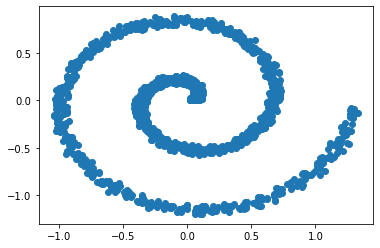

In [3]:
coords = np.array(spiral(1.25, 0.01))
plt.scatter(coords[:, 0], coords[:, 1])

In [4]:
y = np.array([int(np.ceil(i/250)) for i in range(1, 1251)]).reshape(1250, )

In [5]:
n_classes = 5
y = np.floor(np.arange(coords.shape[0])/((1+coords.shape[0])/n_classes)).astype(np.int)

print("Classes: ", np.unique(y))
print("Number of points per class:", [np.sum(y==k) for k in np.unique(y)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(coords, y, test_size=test_size, random_state=random_state)

# note that y_test and X_test is never used below.

Classes:  [0 1 2 3 4]
Number of points per class: [251, 250, 250, 250, 249]


In [6]:
#####DIVIDING DATASETS INTO BATCHES ##### 

#num_lmk = 125          # how many landmarks to find in total
num_lmk_per_batch = 25 # how many landmarks to find per batch
batch_size = 100       # points per batch
n_batches = 2 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 10, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(5 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 0: 200
cat_data shape: 100
cat_data shape: 114
Found 20 landmarks for class 0.
Number of points in class 1: 189
cat_data shape: 100
cat_data shape: 112
Found 17 landmarks for class 1.
Number of points in class 2: 201
cat_data shape: 100
cat_data shape: 113
Found 16 landmarks for class 2.
Number of points in class 3: 203
cat_data shape: 100
cat_data shape: 112
Found 18 landmarks for class 3.
Number of points in class 4: 207
cat_data shape: 100
cat_data shape: 113
Found 17 landmarks for class 4.
Total number of landmarks: 88


In [7]:
x.shape

(1000, 2)

In [8]:
y_train[tot_landmarks].shape

(88,)

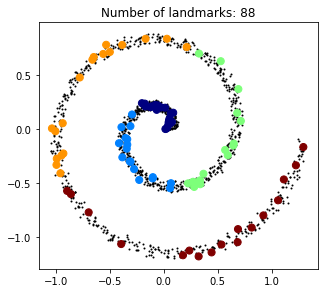

In [9]:
# visualize result

coords = np.array(spiral(1.25, 0.01))

fig,ax =plt.subplots(1,1,figsize=(5,5))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="black")
ax.scatter(X_train[total_landmarks, 0], X_train[total_landmarks, 1], s=50, c=y_train[total_landmarks], cmap="jet")
ax.set_aspect(1)
ax.set_title(f"Number of landmarks: {len(total_landmarks)}");

In [8]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(x_labels.reshape(-1, 1))
onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [9]:
number_of_classes = 5
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [14]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

In [15]:
def landmark_gp_clustering_accuracy(landmarks, landmark_labels, coords, y):
    if(landmarks.shape[0] < 6):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [16]:
np.random.shuffle(tot_landmarks)

In [17]:
accuracies_gp = [landmark_gp_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, 80, 1)]

Landmarks:  6 Accuracy:  0.384
Landmarks:  7 Accuracy:  0.484
Landmarks:  8 Accuracy:  0.524
Landmarks:  9 Accuracy:  0.524
Landmarks:  10 Accuracy:  0.508
Landmarks:  11 Accuracy:  0.644
Landmarks:  12 Accuracy:  0.704
Landmarks:  13 Accuracy:  0.712
Landmarks:  14 Accuracy:  0.748
Landmarks:  15 Accuracy:  0.76
Landmarks:  16 Accuracy:  0.756
Landmarks:  17 Accuracy:  0.764
Landmarks:  18 Accuracy:  0.764
Landmarks:  19 Accuracy:  0.768
Landmarks:  20 Accuracy:  0.768
Landmarks:  21 Accuracy:  0.872
Landmarks:  22 Accuracy:  0.872
Landmarks:  23 Accuracy:  0.872
Landmarks:  24 Accuracy:  0.876
Landmarks:  25 Accuracy:  0.876
Landmarks:  26 Accuracy:  0.876
Landmarks:  27 Accuracy:  0.924
Landmarks:  28 Accuracy:  0.924
Landmarks:  29 Accuracy:  0.932
Landmarks:  30 Accuracy:  0.932
Landmarks:  31 Accuracy:  0.932
Landmarks:  32 Accuracy:  0.932
Landmarks:  33 Accuracy:  0.944
Landmarks:  34 Accuracy:  0.944
Landmarks:  35 Accuracy:  0.944
Landmarks:  36 Accuracy:  0.944
Landmarks:  3

In [18]:
def landmark_clustering_accuracy(landmarks, landmarks_labels, coords, y):
    if(landmarks.shape[0] < 6):
        return 0
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmarks_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [25]:
accuracies_knn = [landmark_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, 80, 1)]

Landmarks:  6 Accuracy:  0.384
Landmarks:  7 Accuracy:  0.468
Landmarks:  8 Accuracy:  0.528
Landmarks:  9 Accuracy:  0.528
Landmarks:  10 Accuracy:  0.724
Landmarks:  11 Accuracy:  0.724
Landmarks:  12 Accuracy:  0.724
Landmarks:  13 Accuracy:  0.772
Landmarks:  14 Accuracy:  0.776
Landmarks:  15 Accuracy:  0.784
Landmarks:  16 Accuracy:  0.784
Landmarks:  17 Accuracy:  0.784
Landmarks:  18 Accuracy:  0.784
Landmarks:  19 Accuracy:  0.784
Landmarks:  20 Accuracy:  0.784
Landmarks:  21 Accuracy:  0.876
Landmarks:  22 Accuracy:  0.876
Landmarks:  23 Accuracy:  0.856
Landmarks:  24 Accuracy:  0.852
Landmarks:  25 Accuracy:  0.852
Landmarks:  26 Accuracy:  0.852
Landmarks:  27 Accuracy:  0.92
Landmarks:  28 Accuracy:  0.92
Landmarks:  29 Accuracy:  0.928
Landmarks:  30 Accuracy:  0.928
Landmarks:  31 Accuracy:  0.928
Landmarks:  32 Accuracy:  0.928
Landmarks:  33 Accuracy:  0.94
Landmarks:  34 Accuracy:  0.94
Landmarks:  35 Accuracy:  0.94
Landmarks:  36 Accuracy:  0.94
Landmarks:  37 Acc

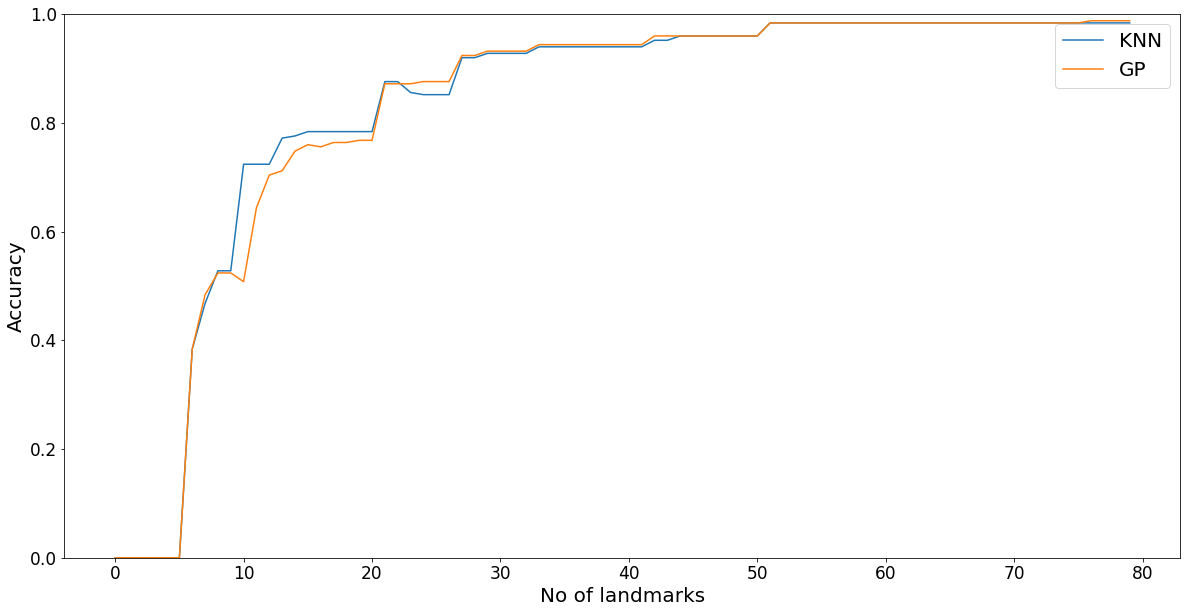

In [31]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, 80, 1), accuracies_knn, label = "KNN")
plt.plot(range(0, 80, 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
#plt.title('Gao algorithm accuracies vs landmarks using KNN and GP' ,fontsize=16)
plt.legend(fontsize=20)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_gao_spiral.png')

In [12]:
count = np.zeros(10)
tot_landmarks = np.array([])
labels = []
x = []
for j in range(5):
    cat_data = []
    new_labels = []
    for i in range(y_train.shape[0]):
        if (y_train[i] == j and count[y_train[i]] < 100):
            new_labels.append(y_train[i])
            cat_data.append(X_train[i])
            count[y_train[i]] += 1
    new_labels = np.array(new_labels)
    cat_data = np.array(cat_data)
    if j==0:
        mgp = ManifoldGP(n_landmarks=18, landmarks=None)
    else:
        mgp = ManifoldGP(n_landmarks=18, landmarks=tot_landmarks)
    mgp.learn_landmarks(cat_data, batch_size = 100)
    tot_landmarks = mgp.landmarks
    labels.append(new_labels)
    x.append(cat_data)
tot_landmarks = np.array(tot_landmarks)
labels = np.array(labels)
labels = labels.reshape(-1, 1)
x = np.array(x)
x.shape

bandwidth:  0.10473805723542201
Learning landmark 0:
Progress: 1000/1000
Learning landmark 1:
Progress: 900/1000

 C:\Users\anany\Desktop\Thesis-files\Paisley_Algorithm.py:141: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
bandwidth:  0.29585250358549703
Learning landmark 0:
Progress: 350/1000

 C:\Users\anany\Desktop\Thesis-files\Paisley_Algorithm.py:141: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
bandwidth:  0.47981656725463706
Learning landmark 0:
Progress: 250/1000

 C:\Users\anany\Desktop\Thesis-files\Paisley_Algorithm.py:141: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
bandwidth:  1.389951668333618
Learning landmark 0:
Progress: 150/1000

 C:\Users\anany\Desktop\Thesis-files\Paisley_Algorithm.py:141: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
bandwidth:  1.3294236389192764
Learning landmark 0:
Progress: 100/1000

 C:\Users\anany\Desktop\Thesis-files\Paisley_Algorithm.py:141: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000


(5, 100, 2)

In [13]:
x = x.reshape(500,2)

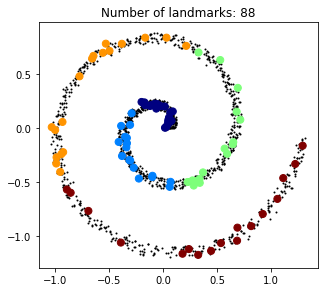

In [14]:
# visualize result

coords = np.array(spiral(1.25, 0.01))

fig,ax =plt.subplots(1,1,figsize=(5,5))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="black")
ax.scatter(X_train[total_landmarks, 0], X_train[total_landmarks, 1], s=50, c=y_train[total_landmarks], cmap="jet")
ax.set_aspect(1)
ax.set_title(f"Number of landmarks: {len(total_landmarks)}");

In [35]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(labels.reshape(-1, 1))
onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [36]:
number_of_classes = 5
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [37]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

In [38]:
kernel = average_variance * RBF(average_lengthscale)
gpc_true = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)

In [39]:
def landmark_gp_paisley_clustering_accuracy(gpc_true, landmarks, coords, y):
    if(landmarks.shape[0] < 6):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    landmark_labels = gpc_true.predict(landmarks)
    labels
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0, max_iter_predict = 1000).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [40]:
accuracies_pgp = [landmark_gp_paisley_clustering_accuracy(gpc_true, tot_landmarks[:i, :], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  6 Accuracy:  0.488
Landmarks:  7 Accuracy:  0.508
Landmarks:  8 Accuracy:  0.592
Landmarks:  9 Accuracy:  0.6
Landmarks:  10 Accuracy:  0.612
Landmarks:  11 Accuracy:  0.62
Landmarks:  12 Accuracy:  0.732
Landmarks:  13 Accuracy:  0.672
Landmarks:  14 Accuracy:  0.724
Landmarks:  15 Accuracy:  0.724
Landmarks:  16 Accuracy:  0.72
Landmarks:  17 Accuracy:  0.716
Landmarks:  18 Accuracy:  0.756
Landmarks:  19 Accuracy:  0.756
Landmarks:  20 Accuracy:  0.732
Landmarks:  21 Accuracy:  0.848
Landmarks:  22 Accuracy:  0.86
Landmarks:  23 Accuracy:  0.88
Landmarks:  24 Accuracy:  0.896
Landmarks:  25 Accuracy:  0.968
Landmarks:  26 Accuracy:  0.968
Landmarks:  27 Accuracy:  0.976
Landmarks:  28 Accuracy:  0.976
Landmarks:  29 Accuracy:  0.976
Landmarks:  30 Accuracy:  0.976
Landmarks:  31 Accuracy:  0.976
Landmarks:  32 Accuracy:  0.964
Landmarks:  33 Accuracy:  0.952
Landmarks:  34 Accuracy:  0.96
Landmarks:  35 Accuracy:  0.78
Landmarks:  36 Accuracy:  0.784
Landmarks:  37 Accur

 C:\Users\anany\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:451: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Landmarks:  83 Accuracy:  0.964
Landmarks:  84 Accuracy:  0.764
Landmarks:  85 Accuracy:  0.764
Landmarks:  86 Accuracy:  0.76
Landmarks:  87 Accuracy:  0.76
Landmarks:  88 Accuracy:  0.76
Landmarks:  89 Accuracy:  0.76


In [42]:
def landmark_paisley_clustering_accuracy(landmarks, coords, y):
    if(landmarks.shape[0] < 6 ):
        return 0
    knn_true = KNeighborsClassifier(n_neighbors=1).fit(coords, y)
    landmark_labels = knn_true.predict(landmarks)
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmark_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [43]:
accuracies_pknn = [landmark_paisley_clustering_accuracy(tot_landmarks[:i, :], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  6 Accuracy:  0.448
Landmarks:  7 Accuracy:  0.448
Landmarks:  8 Accuracy:  0.5
Landmarks:  9 Accuracy:  0.5
Landmarks:  10 Accuracy:  0.5
Landmarks:  11 Accuracy:  0.6
Landmarks:  12 Accuracy:  0.668
Landmarks:  13 Accuracy:  0.636
Landmarks:  14 Accuracy:  0.696
Landmarks:  15 Accuracy:  0.7
Landmarks:  16 Accuracy:  0.7
Landmarks:  17 Accuracy:  0.708
Landmarks:  18 Accuracy:  0.708
Landmarks:  19 Accuracy:  0.708
Landmarks:  20 Accuracy:  0.7
Landmarks:  21 Accuracy:  0.812
Landmarks:  22 Accuracy:  0.836
Landmarks:  23 Accuracy:  0.856
Landmarks:  24 Accuracy:  0.868
Landmarks:  25 Accuracy:  0.928
Landmarks:  26 Accuracy:  0.944
Landmarks:  27 Accuracy:  0.944
Landmarks:  28 Accuracy:  0.944
Landmarks:  29 Accuracy:  0.944
Landmarks:  30 Accuracy:  0.944
Landmarks:  31 Accuracy:  0.944
Landmarks:  32 Accuracy:  0.944
Landmarks:  33 Accuracy:  0.944
Landmarks:  34 Accuracy:  0.944
Landmarks:  35 Accuracy:  0.944
Landmarks:  36 Accuracy:  0.944
Landmarks:  37 Accuracy:  

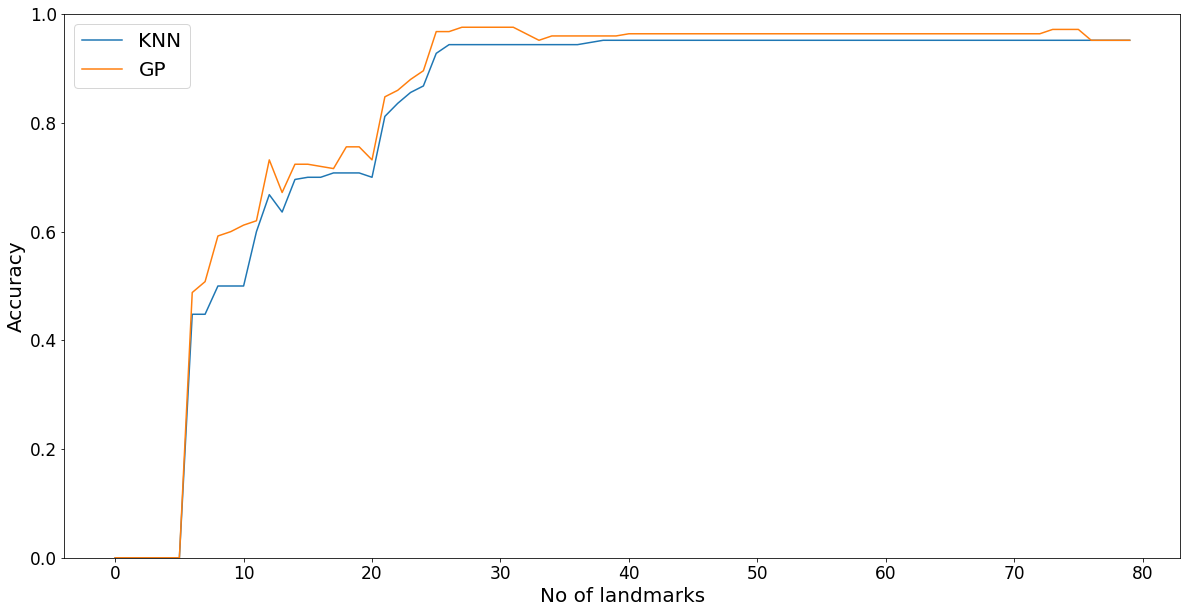

In [50]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, 80, 1), accuracies_pknn, label = "KNN")
plt.plot(range(0, 80, 1), accuracies_pgp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
#plt.title('Gao algorithm accuracies vs landmarks using KNN and GP' ,fontsize=16)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_spiral_spiral.png')

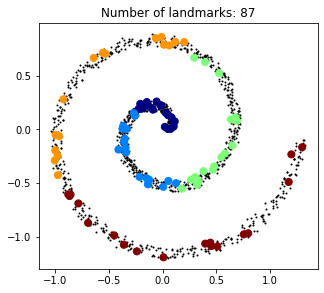

In [217]:
# visualize result

coords = np.array(spiral(1.25, 0.01))

fig,ax =plt.subplots(1,1,figsize=(5,5))
ax.scatter(coords[:, 0], coords[:, 1], s=1, c="black")
ax.scatter(X_train[total_landmarks, 0], X_train[total_landmarks, 1], s=50, c=y_train[total_landmarks], cmap="jet")
ax.set_aspect(1)
ax.set_title(f"Number of landmarks: {len(total_landmarks)}");